### Equipo: 

- Nombre de alumno 1: Nicolas Herrera
- Nombre de alumno 2: Lucas Carrasco

### **Link de repositorio de GitHub:** [Repositorio](https://github.com/vspartamo/MDS7202)

### Indice
1. [Introducción](#Introducción:)
2. [Análisis Exploratorio de Datos](#Análisisexploratoriodedatos:)

# Introducción

**DEBE CONTENER**

Esta sección debe incluir:  
- Una descripción breve del problema planteado: ¿Qué se busca predecir?  
- Un resumen de los datos de entrada proporcionados.  
- La métrica seleccionada para evaluar los modelos, con su respectiva justificación. Dado que los datos están desbalanceados, se recomienda evitar el uso de `accuracy` y centrarse en métricas como `precision`, `recall` o `f1-score`, especificando la clase de interés.  
- Una mención breve de los modelos empleados para abordar el problema, incluyendo las transformaciones intermedias aplicadas a los datos.  
- Un análisis general de los resultados obtenidos, señalando si el modelo final cumplió con los objetivos planteados y cómo se posicionó frente a los de otros equipos.

## **2 Preprocesamiento**
### **2.1 Análisis exploratorio de datos**


Se realiza un análisis exploratorio de datos para identificar patrones, tendencias y relaciones en ellos. Esto para comprender mejor las características del conjunto de datos y guiar las siguientes decisiones en el pipeline de modelamiento.

In [2]:
#%pip install pyarrow pandas scikit-learn matplotlib seaborn

In [5]:
# Se importan las librerías básicas para trabajar los datos y visualizarlos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_PATH = "data/"
X_t0 = pd.read_parquet(DATA_PATH + "X_t0.parquet")
y_t0 = pd.read_parquet(DATA_PATH + "y_t0.parquet")

df_t0 = pd.concat([X_t0, y_t0], axis=1)
df_t0.head()

In [ ]:
df_t0.columns

Se entrega una breve descripción de cada una de las 78 columnas:
#### **Datos generales del wallet**
- **`borrow_block_number`**: Número del bloque en el que ocurrió el préstamo más reciente asociado al monedero.
- **`borrow_timestamp`**: Marca de tiempo (timestamp) del préstamo más reciente.
- **`wallet_address`**: Dirección del monedero que identifica al usuario.
- **`first_tx_timestamp`**: Timestamp de la primera transacción registrada para este monedero.
- **`last_tx_timestamp`**: Timestamp de la última transacción registrada.
- **`wallet_age`**: Tiempo total desde la primera transacción hasta la fecha actual, generalmente en días o meses.

#### **Estadísticas de transacciones**
- **`incoming_tx_count`**: Número total de transacciones entrantes al monedero.
- **`outgoing_tx_count`**: Número total de transacciones salientes desde el monedero.
- **`net_incoming_tx_count`**: Diferencia entre las transacciones entrantes y salientes.
- **`total_gas_paid_eth`**: Cantidad total de gas pagado en ETH por todas las transacciones.
- **`avg_gas_paid_per_tx_eth`**: Promedio de gas pagado por transacción, expresado en ETH.

#### **Datos sobre transacciones riesgosas**
- **`risky_tx_count`**: Número de transacciones clasificadas como riesgosas.
- **`risky_unique_contract_count`**: Número de contratos únicos involucrados en transacciones riesgosas.
- **`risky_first_tx_timestamp`**: Timestamp de la primera transacción riesgosa.
- **`risky_last_tx_timestamp`**: Timestamp de la última transacción riesgosa.
- **`risky_first_last_tx_timestamp_diff`**: Diferencia temporal entre la primera y la última transacción riesgosa.
- **`risky_sum_outgoing_amount_eth`**: Suma de ETH enviados en transacciones riesgosas.

#### **Estadísticas de ETH en el monedero**
- **`outgoing_tx_sum_eth`**: Suma total de ETH enviados en todas las transacciones salientes.
- **`incoming_tx_sum_eth`**: Suma total de ETH recibidos en todas las transacciones entrantes.
- **`outgoing_tx_avg_eth`**: Promedio de ETH enviados por transacción saliente.
- **`incoming_tx_avg_eth`**: Promedio de ETH recibidos por transacción entrante.
- **`max_eth_ever`**: Máximo balance de ETH alcanzado en el monedero.
- **`min_eth_ever`**: Mínimo balance de ETH registrado en el monedero.
- **`total_balance_eth`**: Balance actual del monedero en ETH.
- **`risk_factor`**: Indicador del nivel de riesgo asociado al monedero, basado en algún modelo de análisis.

#### **Estadísticas de préstamos y colaterales**
- **`total_collateral_eth`**: Suma total de ETH utilizados como colateral.
- **`total_collateral_avg_eth`**: Promedio de ETH usados como colateral por préstamo.
- **`total_available_borrows_eth`**: Monto total de ETH disponible para préstamo.
- **`total_available_borrows_avg_eth`**: Promedio de ETH disponibles para préstamo.
- **`avg_weighted_risk_factor`**: Factor de riesgo ponderado promedio.
- **`risk_factor_above_threshold_daily_count`**: Número de días en los que el factor de riesgo estuvo por encima de un umbral predefinido.
- **`avg_risk_factor`**: Promedio del factor de riesgo del monedero.
- **`max_risk_factor`**: Máximo valor del factor de riesgo registrado.
- **`borrow_amount_sum_eth`**: Suma total de ETH prestados.
- **`borrow_amount_avg_eth`**: Promedio de ETH prestados por transacción.
- **`borrow_count`**: Número total de transacciones de préstamo.
- **`repay_amount_sum_eth`**: Suma total de ETH devueltos.
- **`repay_amount_avg_eth`**: Promedio de ETH devueltos por transacción.
- **`repay_count`**: Número total de transacciones de devolución.
- **`borrow_repay_diff_eth`**: Diferencia entre ETH prestados y devueltos.

#### **Estadísticas de depósitos y retiros**
- **`deposit_count`**: Número de transacciones de depósito realizadas.
- **`deposit_amount_sum_eth`**: Suma total de ETH depositados.
- **`time_since_first_deposit`**: Tiempo transcurrido desde el primer depósito.
- **`withdraw_amount_sum_eth`**: Suma total de ETH retirados.
- **`withdraw_deposit_diff_if_positive_eth`**: Diferencia positiva entre ETH retirados y depositados.
- **`liquidation_count`**: Número de veces que el monedero fue liquidado.
- **`time_since_last_liquidated`**: Tiempo transcurrido desde la última liquidación.
- **`liquidation_amount_sum_eth`**: Suma total de ETH liquidados.

#### **Indicadores del mercado**
- **`market_adx`, `market_adxr`, `market_apo`, etc.**: Indicadores técnicos basados en análisis del mercado, como fuerza direccional (ADX), Momentum, osciladores (Aroon), volatilidad (ATR), fuerza relativa (CCI), entre otros. Estos se usan comúnmente para evaluar tendencias o comportamientos del mercado.

#### **Estadísticas adicionales**
- **`unique_borrow_protocol_count`**: Número de protocolos de préstamos únicos utilizados.
- **`unique_lending_protocol_count`**: Número de protocolos de préstamos ofrecidos.
- **`target`**: Variable objetivo, posiblemente para un modelo de predicción (como riesgo de impago o clasificación).

### **Limpieza de los datos**

Se remueve las columnas que corresponden a identificadores o no aportan información relevante al problema.

In [ ]:
columns_to_drop = [
    'borrow_block_number',
    'wallet_address',
    'borrow_timestamp',
    'first_tx_timestamp',
    'last_tx_timestamp',
    'risky_first_tx_timestamp',
    'risky_last_tx_timestamp',
    'unique_borrow_protocol_count',
    'unique_lending_protocol_count',
]

df_t0_columns_dropped = df_t0.drop(columns=columns_to_drop, inplace=False)

df_t0_columns_dropped.shape

In [ ]:
#vemos la existencia de nulos
sum(df_t0_columns_dropped.isna().sum() > 0)

In [ ]:
df_t0_columns_dropped.info()

In [ ]:
#identificamos las columnas numericas, no hay categoricas
numeric_features = df_t0_columns_dropped.select_dtypes(include=['int64', 'float64']).columns
train_numeric_features = numeric_features.drop('target')
# identificar las columnas categoricas
categoric_features = df_t0_columns_dropped.select_dtypes(include = ['object']).columns
categoric_features 

In [ ]:
#estadísticas generales de las columnas numéricas
print(df_t0_columns_dropped.describe())

In [ ]:
# ver el desbalance de clases en la columna target 
df_t0_columns_dropped['target'].value_counts(normalize=True)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_numeric_histograms(df, numeric_features, n_cols=6, title="Análisis Univariado de las Variables Numéricas"):
    """
    Función para graficar histogramas de variables numéricas en un DataFrame.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene las variables a graficar.
    - numeric_features (list): Lista de nombres de las columnas numéricas a graficar.
    - n_cols (int): Número de columnas en la cuadrícula de subplots.
    - title (str): Título del gráfico.
    """
    # Crear subplots dinámicamente según la cantidad de variables
    n_rows = len(numeric_features) // n_cols + (1 if len(numeric_features) % n_cols != 0 else 0)
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=numeric_features)

    for idx, col in enumerate(numeric_features):
        row_idx = idx // n_cols + 1
        col_idx = idx % n_cols + 1

        hist = go.Histogram(x=df.loc[:, col], name=col, histnorm="probability")
        fig.add_trace(hist, row=row_idx, col=col_idx)
    fig.update_layout(
        height=400 * n_rows,  
        title_text=title,
        showlegend=False,
    )

    fig.show()


In [14]:
import matplotlib.pyplot as plt
import math

def plot_numeric_histograms(df, numeric_features, n_cols=6, title="Análisis Univariado de las Variables Numéricas"):
    """
    Función para graficar histogramas de variables numéricas en un DataFrame usando Matplotlib.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene las variables a graficar.
    - numeric_features (list): Lista de nombres de las columnas numéricas a graficar.
    - n_cols (int): Número de columnas en la cuadrícula de subplots.
    - title (str): Título del gráfico.
    """
    # Calcular el número de filas necesarias
    n_rows = math.ceil(len(numeric_features) / n_cols)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()  # Asegurar que sea un array plano para indexar

    # Iterar sobre cada variable numérica y graficar
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        ax.hist(df[col], bins=30, density=True, color="skyblue", edgecolor="black")
        ax.set_title(col, fontsize=12)
        ax.set_xlabel("Valores", fontsize=10)
        ax.set_ylabel("Frecuencia", fontsize=10)

    # Eliminar ejes sobrantes si hay menos gráficos que espacios
    for idx in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[idx])

    # Ajustar el layout y agregar título general
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [15]:
chunk_size = len(numeric_features) // 3
numeric_features_1 = numeric_features[:chunk_size]
numeric_features_2 = numeric_features[chunk_size:2*chunk_size]
numeric_features_3 = numeric_features[2*chunk_size:]

In [ ]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_1)

In [ ]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_2)

In [ ]:
plot_numeric_histograms(df_t0_columns_dropped, numeric_features_3)

In [ ]:
# Se estudia la correlación de features
correlation_matrix = df_t0_columns_dropped[numeric_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

In [26]:
def get_top_correlated_groups(df, n=10, m=2):
    """
    Función para obtener los n grupos de m columnas más relacionadas entre sí.

    Parameters:
    - df (pd.DataFrame): DataFrame que contiene las columnas a analizar.
    - n (int): Número de grupos a retornar.
    - m (int): Número de columnas en cada grupo.

    Returns:
    - list: Lista de tuplas, donde cada tupla contiene las columnas de un grupo y su correlación promedio.
    """
    corr_matrix = df.corr().abs()  # Matriz de correlación absoluta
    np.fill_diagonal(corr_matrix.values, 0)  # Ignorar la diagonal principal

    groups = []
    used_columns = set()

    for _ in range(n):
        # Encontrar el par de columnas más correlacionadas no utilizadas
        max_corr = corr_matrix.max().max()
        idx = corr_matrix.stack().idxmax()
        top_features = list(idx)

        # Agregar las columnas adicionales más correlacionadas si m > 2
        if m > 2:
            remaining_corrs = corr_matrix.loc[top_features].mean(axis=0).sort_values(ascending=False)
            for col in remaining_corrs.index:
                if col not in used_columns and col not in top_features:
                    top_features.append(col)
                if len(top_features) == m:
                    break

        # Calcular la correlación promedio del grupo
        avg_corr = corr_matrix.loc[top_features, top_features].mean().mean()
        groups.append((tuple(top_features), avg_corr))

        # Actualizar columnas utilizadas y matriz de correlación
        used_columns.update(top_features)
        corr_matrix.loc[top_features, :] = 0
        corr_matrix.loc[:, top_features] = 0

    return groups


In [ ]:
get_top_correlated_groups(df_t0_columns_dropped, 10, 2)

In [ ]:
# se obtiene las 10 variables más correlacionadas con 'target', pero su correlación es muy baja para considerarlas relevantes
correlations = df_t0_columns_dropped.corr(numeric_only=True)['target'].dropna()
correlations_sorted = correlations.abs().sort_values(ascending=False)
top_10_correlated_variables = correlations_sorted.index[1:11]  
print("10 variables más correlacionadas con 'target':")
print(correlations[top_10_correlated_variables])


In [ ]:
df_t0_columns_dropped.columns[np.argmax(vars)]

In [ ]:
# se estudiará la distribución de las 3 variables más correlacionadas con 'target'
top_3_correlated_variables = correlations_sorted.index[1:4]
def plot_distributions_grid_stacked(df, max_plots_per_row=3, hue=None, normalize=False, clip_percentiles=(1, 99)):
    """
    Plots a grid of histograms with stacked bars and overlaid KDE lines for each column in a DataFrame.
    Each plot has its own scale for both X and Y axes.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data to plot.
    - max_plots_per_row (int): Maximum number of plots per row.
    - hue (str): Column name to use for coloring the plots (optional).
    - normalize (bool): Whether to normalize histograms for comparison.
    - clip_percentiles (tuple): Percentiles to clip the data for better visualization.
    """
    # Calculate the grid dimensions
    num_columns = len(df.columns)
    if hue in df.columns:
        num_columns -= 1  # Exclude hue column from plotting
    
    num_rows = int(np.ceil(num_columns / max_plots_per_row))
    
    fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(5 * max_plots_per_row, 4 * num_rows))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    columns_to_plot = [col for col in df.columns if col != hue]
    
    # Plot each column
    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        # Clip data to remove outliers
        lower, upper = np.percentile(df[column], clip_percentiles)
        clipped_data = df[(df[column] >= lower) & (df[column] <= upper)]
        
        if hue and hue in df.columns:
            # Plot stacked histogram
            sns.histplot(data=clipped_data, x=column, hue=hue, kde=False, 
                         stat='density' if normalize else 'count', ax=ax, element="bars", multiple="stack")
            # Add overlaid KDE lines
            sns.kdeplot(data=clipped_data, x=column, hue=hue, ax=ax, common_norm=normalize, legend=False)
        else:
            sns.histplot(clipped_data[column], kde=True, stat='density' if normalize else 'count', ax=ax)
        
        ax.set_title(column)
        ax.set_xlim(lower, upper)  # Set x-axis limits to clipped range
    
    # Remove unused subplots
    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

to_plot_cols = top_3_correlated_variables.tolist() + ['target']
plot_distributions_grid_stacked(df_t0_columns_dropped[to_plot_cols], max_plots_per_row=3, hue='target', normalize=True)

## Resumen y conclusiones

**Hay q escribirlo bonito y ver si hay algo más**
Hecho el Análisis Exploratorio de Datos se obtuve las siguientes observaciones:
 
- Se debe eliminar columnas que no aportan información relevantes, entre ellas las del tipo timestamp o identificadores.

- No hay nulos ni blancos en X_t0, por lo que en esta instancia no es necesario realizar una imputación o filtrado de datos.

- El desbalance de clase en la columna target es despreciable en el dataset inicial "X_t0" por lo que no se considerará que esta variable tenga desbalance.

- No hay columnas categóricas, por lo que no será necesario implementar en el preprocesamiento pasos relacionados a esto.

- Existen diversas variables que concentran sus valores en 0, lo que pareciera no aportar información relevante. 
- Las variables no muestran una distribución normal, por lo que al escalarlas no se utilizará StandarScaler si no MinMaxScaler.

- No existen pares de columnas que tengan una alta correlación, por lo que estas no son redundantes entre sí.

- No existen columnas con una alta correlación a la variable target.

Con esto en consideración, se concluye el análisis exploratorio de datos.


### **2.2 Preprocesamiento de Datos**

Luego de un primer acercamiento a los datos, se procede a realizar un preprocesamiento de estos.


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())   # se escoge minmax scaler dado que los datos no tienen una distribución normal en ninguna feature

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.drop('target'))
    ]
)


In [33]:
from sklearn.model_selection import train_test_split

X = df_t0_columns_dropped.drop(columns='target')
y = df_t0_columns_dropped['target']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y_t0, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((31007, 68), (6644, 68), (6645, 68))

In [34]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

## **3. Modelamiento**
### **3.1 Baseline** 
Se implementa un baseline, para ello se elige Decision Tree  y se crea una función que englobe los Pipelines y retorne métricas de interés. En lo siguiente, consideraremos como métrica objetivo AUC porque se trabaja un problema de clasificación binaria donde es importante distinguir adecuadamente ambas clases por igual.


In [37]:
#Para entrenar tanto el baseline como modelos futuros, se escribe las siguientes 
# funciones que serán importantes

from sklearn.base import BaseEstimator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import optuna
import pandas as pd
import mlflow
import os
import pickle
from typing import List


def train_or_update_model(
    model: BaseEstimator | str,
    X_train: pd.DataFrame,
    y_train: pd.Series | np.ndarray,
    X_val: pd.DataFrame,
    y_val: pd.Series | np.ndarray,
    experiment_name: str,
    numeric_features: pd.Index | List[str],
    save_model_path: str = "",
    scaler=None,
    use_pca=False,
    pca_components=50,
    retrain=False,
    preprocessor=None,
    fun_to_update_model=None,
    use_optuna=False,
    n_trials=50,
):
    """
    Entrena o reentrena un modelo con pipeline, manejando incrementalidad y optimización de hiperparámetros.

    Args:
    - model: Clasificador base (debe soportar `partial_fit` si `retrain=True`) o ruta a un modelo guardado.
    - X_train, y_train: Datos de entrenamiento.
    - X_val, y_val: Datos de validación.
    - experiment_name: Nombre del experimento en MLflow.
    - numeric_features: Lista de columnas numéricas.
    - save_model_path: Ruta para guardar el modelo.
    - scaler: Escalador para características numéricas (Default: StandardScaler).
    - use_pca: Si True, aplica PCA a las características numéricas.
    - pca_components: Número de componentes principales para PCA.
    - retrain: Si True, reentrena un modelo existente.
    - preprocessor: Preprocesador ya ajustado para reutilizar.
    - fun_to_update_model (callable): Función para actualizar el modelo. Recibe (modelo, X, y).
    - use_optuna: Si True, utiliza Optuna para optimizar hiperparámetros.
    - n_trials: Número de iteraciones para Optuna.

    Returns:
    - Tuple: (pipeline completo, clasificador base).
    """
    if scaler is None:
        scaler = StandardScaler()

    # Crear pipeline de preprocesamiento si no existe
    if preprocessor is None:
        numeric_transformer_steps = [("scaler", scaler)]
        if use_pca:
            numeric_transformer_steps.append(("pca", PCA(n_components=pca_components)))
        numeric_transformer = Pipeline(steps=numeric_transformer_steps)


        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features)
            ]
        )

    mlflow.set_experiment(experiment_name)

    # Optimización de hiperparámetros con Optuna
    if use_optuna:
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            }

            temp_model = model.set_params(**params)
            pipeline = Pipeline(
                steps=[("preprocessor", preprocessor), ("classifier", temp_model)]
            )
            pipeline.fit(X_train, y_train)
            y_val_pred = pipeline.predict(X_val)
            val_auc = roc_auc_score(y_val, pipeline.predict_proba(X_val)[:, 1])
            return val_auc

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        model.set_params(**best_params)

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    with mlflow.start_run():
        pipeline.fit(X_train, y_train)

        # Registrar el nombre del modelo y parámetros
        mlflow.log_param("model_name", model.__class__.__name__)
        if use_optuna:
            mlflow.log_params(best_params)

        # Evaluar el modelo
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)

        train_auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
        val_auc = roc_auc_score(y_val, pipeline.predict_proba(X_val)[:, 1])

        train_metrics = {
            "accuracy": accuracy_score(y_train, y_train_pred),
            "precision": precision_score(y_train, y_train_pred, average="binary"),
            "recall": recall_score(y_train, y_train_pred, average="binary"),
            "f1_score": f1_score(y_train, y_train_pred, average="binary"),
            "auc": train_auc,
        }
        mlflow.log_metrics({f"train_{k}": v for k, v in train_metrics.items()})

        val_metrics = {
            "accuracy": accuracy_score(y_val, y_val_pred),
            "precision": precision_score(y_val, y_val_pred, average="binary"),
            "recall": recall_score(y_val, y_val_pred, average="binary"),
            "f1_score": f1_score(y_val, y_val_pred, average="binary"),
            "auc": val_auc,
        }
        mlflow.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})

        # Guardar el modelo
        if save_model_path:
            with open(save_model_path, "wb") as f:
                pickle.dump(pipeline, f)

        # Imprimir métricas
        print(f"Model to train/retrain: {model.__class__.__name__}")
        print("\n--- Training Metrics ---")
        for k, v in train_metrics.items():
            print(f"{k.capitalize()}: {v}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_train, y_train_pred))
        print("\nClassification Report:")
        print(classification_report(y_train, y_train_pred))

        print("\n--- Validation Metrics ---")
        for k, v in val_metrics.items():
            print(f"{k.capitalize()}: {v}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_val, y_val_pred))
        print("\nClassification Report:")
        print(classification_report(y_val, y_val_pred))

    return pipeline, model


In [58]:
import os
import pickle
from typing import Callable, List, Union
import mlflow
import optuna
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def create_preprocessor(
    numeric_features: Union[pd.Index, List[str]],
    
    scaler=None,
    use_pca=False,
    pca_components=50,
):
    if scaler is None:
        scaler = StandardScaler()

    # Define numeric transformer
    numeric_transformer_steps = [("scaler", scaler)]
    if use_pca:
        numeric_transformer_steps.append(("pca", PCA(n_components=pca_components)))
    numeric_transformer = Pipeline(steps=numeric_transformer_steps)



    # Combine preprocessors
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features)
        ]
    )

    return preprocessor


def create_pipeline(
    model: BaseEstimator,
    preprocessor: ColumnTransformer,
):
    return Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])


def optimize_hyperparameters(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    get_optuna_params: Callable,
    experiment_name: str,
    n_trials: int = 50,
    direction: str = "maximize",
):
    def objective(trial: optuna.Trial):
        run_name = f"trial_{trial.number}_optimization"
        with mlflow.start_run(run_name=run_name, nested=True):
            optuna_params = get_optuna_params(trial)
            model.set_params(**optuna_params)
            mlflow.log_params(optuna_params)
            
            model.fit(X_train, y_train)

            # Optimizamos sobre el AUC ROC
            y_proba_pred = model.predict_proba(X_train)[:, 1]
            roc_auc = roc_auc_score(y_train, y_proba_pred)
            mlflow.log_metric("roc_auc", roc_auc)
            
            return roc_auc

    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name="optuna_study"):
        study = optuna.create_study(direction=direction)
        study.optimize(objective, n_trials=n_trials)
        mlflow.end_run()

    # Log best parameters in a separate run
    with mlflow.start_run(run_name="best_params", nested=False):
        mlflow.log_params(study.best_params)

    return study.best_params


def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="binary"),
        "recall": recall_score(y_true, y_pred, average="binary"),
        "f1_score": f1_score(y_true, y_pred, average="binary"),
        "roc_auc": (
            roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
        ),
    }
    print(f"Métricas del modelo:")
    for k, v in metrics.items():
        print(f"    {k}: {v}")
    print(f"Confusion matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Classification report:\n{classification_report(y_true, y_pred)}")
    return metrics


def log_metrics(metrics: dict, prefix: str):
    mlflow.log_metrics({f"{prefix}_{k}": v for k, v in metrics.items()})


def save_model(pipeline: Pipeline, save_model_path: str):
    with open(save_model_path, "wb") as f:
        pickle.dump(pipeline, f)


def train_model(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    X_val: pd.DataFrame,
    y_val: Union[pd.Series, np.ndarray],
    numeric_features: Union[pd.Index, List[str]],
    experiment_name: str,
    save_model_path: str = None,
    scaler=None,
    use_pca=False,
    pca_components=50,
    optimize: bool = False,
    get_optuna_params: Callable = None,
    n_trials: int = 50,
):
    mlflow.set_experiment(experiment_name)

    # Create preprocessor
    preprocessor = create_preprocessor(
        numeric_features, scaler, use_pca, pca_components
    )

    # Optimize hyperparameters if required
    if optimize and get_optuna_params:
        best_params = optimize_hyperparameters(
            model, X_train, y_train, get_optuna_params, experiment_name, n_trials
        )
        mlflow.end_run()
        model.set_params(**best_params)

    # Create pipeline
    pipeline = create_pipeline(model, preprocessor)

    # Train the pipeline
    with mlflow.start_run(run_name="best_params_training"):
        pipeline.fit(X_train, y_train)

        # Log metrics
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)

        if hasattr(model, "predict_proba"):
            y_train_proba_pred = pipeline.predict_proba(X_train)[:, 1]
            y_val_proba_pred = pipeline.predict_proba(X_val)[:, 1]
        else:
            y_train_proba_pred = None
            y_val_proba_pred = None

        print("Evaluación del modelo en el conjunto de entrenamiento:")
        train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba_pred)
        print("Evaluación del modelo en el conjunto de validación:")
        val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba_pred)

        log_metrics(train_metrics, "train")
        log_metrics(val_metrics, "val")

        if save_model_path:
            # Save model and preprocessor
            save_model(pipeline, save_model_path)

    return pipeline


def retrain_model(
    pipeline_or_path: Union[str, Pipeline],
    X: pd.DataFrame,
    y: Union[pd.Series, np.ndarray],
    fun_to_update_model: Callable,
    save_model_path: str,
    test_size: float = 0.2,
    random_state: int = 42,
    optimize: bool = False,
    get_optuna_params: Callable = None,
    n_trials: int = 50,
):
    if isinstance(pipeline_or_path, str):
        with open(pipeline_or_path, "rb") as f:
            pipeline = pickle.load(f)
    else:
        pipeline = pipeline_or_path

    preprocessor = pipeline.named_steps["preprocessor"]
    model: BaseEstimator = pipeline.named_steps["classifier"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train_transformed = preprocessor.transform(X_train)

    if optimize and get_optuna_params:
        best_params = optimize_hyperparameters(
            model,
            X_train_transformed,
            y_train,
            get_optuna_params,
            "retraining_optimization",
            n_trials,
        )
        model.set_params(**best_params)

    model = fun_to_update_model(model, X_train_transformed, y_train)

    pipeline = create_pipeline(model, preprocessor)
    save_model(pipeline, save_model_path)

    X_test_transformed = preprocessor.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    y_pred_proba = (
        model.predict_proba(X_test_transformed)[:, 1]
        if hasattr(model, "predict_proba")
        else None
    )

    print("Evaluación en el conjunto de prueba:")
    evaluate_model(y_test, y_pred, y_pred_proba)

    return pipeline

In [52]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_pipe, _ = train_model(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic Decision Tree",
    numeric_features=train_numeric_features,
)

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 1.0
    precision: 1.0
    recall: 1.0
    f1_score: 1.0
    roc_auc: 1.0
Confusion matrix:
[[15148     0]
 [    0 15859]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15148
           1       1.00      1.00      1.00     15859

    accuracy                           1.00     31007
   macro avg       1.00      1.00      1.00     31007
weighted avg       1.00      1.00      1.00     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.8263094521372667
    precision: 0.8248407643312102
    recall: 0.8384343731606827
    f1_score: 0.8315820198482194
    roc_auc: 0.8260255661243956
Confusion matrix:
[[2641  605]
 [ 549 2849]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      3246
           1       0.82 

### **3.2 Modelos de Machine Learning**

Hecho el baseline, se implementará Random Forest, XGBoost, CatBoost y LGBoost.

- Random Forest: Es un modelo de basado en árboles de decisión que utiliza aglomerativamente el conocimiento obtenido de cada uno. Cada árbol entrena sobre una muestra random del conjunto de datos y se utiliza una selección aleatoria de características para hacer la división de nodos. Los hiperparámetros iniciales de este modelo son `n_estimators` que corresponde al número de árboles por bosque, que por docente son 100. `max_depth` que es la profundidad máxima de los árboles que a priori es `None`, lo que quiere decir que los nodos se expanden hasta quetodas las hojas son puras o contienen menos muestras que `min_samples_split`, este parámetro corresponde a la cantidad mínima de muestras requeridas para dividir un nodo interno, su valor por defecto es 2. 
`min_samples_leaf` es el número mínimo de muestras requeridas para que se considere hoja, su valor por defecto es setado como 1,


- XGBoost: es un modelo basado en árboles de decisión que utiliza boosting mediante un entrenamiento secuencial de modelos con gradientes, se caracteriza por ser de rápido tiempo de ejecución. Entre los hiperpárametros del modelo se encuentran `n_estimators` que se ajusta igualmente que en RandomForest, `max_depth` es el mismo hiperparámetro descrito anteriormente sólo que en este modelo su valor por defecto es $6$. Otros hiperparámetros que se ajustan por defecto son `learning_rate` que es la tasa de aprendizaje que ajusta la contribución de cada árbol, su valor por defecto es $0.1$, `subsample` es la proporción se muestras utilizadas para contruir cada árbol y su valor por defecto es $1.0$, otro hiperparámetro importante es `reg_alpha` que es la regularización L1 ajustada por defecto como desactivada y en cambio se tiene activada `reg_lambda` que es la regularización L2 que es la que se implementa por defecto.

- LGBoost: Es un modelo similar a XGBoost en el sentido de usar boosting, solo que lo hace sobre histogramas, es especialmente útil para datos de gran embergadura que requieran un entrenamiento rápido. Sus hiperparametros seteados de por defecto son `n_estimators` (100), `learning_rate` (0.1), `max_depth` (-1, sin límite), `num_leaves` (31), `lambda_l1` (0, i.e desactivado), `lambda_l2` (0, i.e desactivado) que se ajustan por defecto con los valores dados en los paréntesis.


In [55]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipe, _ = train_model(
    model=RandomForestClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic Random Forest",
    numeric_features=train_numeric_features
)

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 1.0
    precision: 1.0
    recall: 1.0
    f1_score: 1.0
    roc_auc: 1.0
Confusion matrix:
[[15148     0]
 [    0 15859]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15148
           1       1.00      1.00      1.00     15859

    accuracy                           1.00     31007
   macro avg       1.00      1.00      1.00     31007
weighted avg       1.00      1.00      1.00     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.8944912703190849
    precision: 0.935702746365105
    recall: 0.8522660388463802
    f1_score: 0.8920375789311566
    roc_auc: 0.9597828921147846
Confusion matrix:
[[3047  199]
 [ 502 2896]]
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3246
           1       0.94  

#### **XGBoost**

In [54]:
from xgboost import XGBClassifier

# Entrenar el modelo con XGBoost
xgboost_pipe, _ = train_model(
    model=XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic XGBoost",
    numeric_features=train_numeric_features
)

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9512368174928242
    precision: 0.9786481617401748
    recall: 0.9248376316287281
    f1_score: 0.9509822991635869
    roc_auc: 0.9916981588457949
Confusion matrix:
[[14828   320]
 [ 1192 14667]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     15148
           1       0.98      0.92      0.95     15859

    accuracy                           0.95     31007
   macro avg       0.95      0.95      0.95     31007
weighted avg       0.95      0.95      0.95     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.885009030704395
    precision: 0.9146725440806045
    recall: 0.8549146556798116
    f1_score: 0.8837846060237299
    roc_auc: 0.9515175013245804
Confusion matrix:
[[2975  271]
 [ 493 2905]]
Classification report:
              precision    recall  f1-score   support

    

#### **LGBoost**

In [ ]:
from lightgbm import LGBMClassifier

# Entrenar el modelo con LightGBM
lightgbm_pipe, _ = train_model(
    model=LGBMClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Basic LightGBM",
    numeric_features=train_numeric_features
)

[LightGBM] [Info] Number of positive: 15859, number of negative: 15148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15502
[LightGBM] [Info] Number of data points in the train set: 31007, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511465 -> initscore=0.045869
[LightGBM] [Info] Start training from score 0.045869

--- Train Metrics ---
Accuracy: 0.8817363821072661
Precision: 0.9371145848271906
Recall: 0.824074657922946
F1_score: 0.8769669518537159
Auc: 0.9576119359420247

--- Validation Metrics ---
Accuracy: 0.8600240818783865
Precision: 0.9067237969676994
Recall: 0.8095938787522072
F1_score: 0.855410447761194
Auc: 0.9318753610637549


Nuestra métrica objetivo es AUC, por lo que XGBoost  es el modelo que funciona mejor, esto notando que el baseline obtuvo en el conjunto de entrenamiento $1.0$ y en validation $0.82$, es decir, se sobreajustó, mientras que XGBoost mostró un desempeñó consistentemente bueno, obteniendo AUC de $0.99$ en train y $0.95$ en validation, y como muestra una diferencia menor a un 5%  (es 4%) se considera que no realizó overfitting pese a que obtiene resultados demasiado buenos en train. Esto se puede explicar dado que XGBoost implementa regularización que es una medida para prevenir el overfitting, los árboles de DecisionTree pueden ser más profundos de lo ideal llevándolo a sobre entrenarse o bien, por la naturaleza misma de los modelos en cuestión, ya que XGBoost está preparado para capturar patrones con más complejidad que DecisionTree. 
Por otra parte, DecisionTree se ejecuta más lento que XGBoost, demorando aproximadamente 8 segundos mientras que XGBoost rondea los 3 segundos, esto es relativamente esperable dado que XGBoos es conocido por ser de rápidos tiempo de ejecución. Con todo, se elige este modelo para las siguientes etapas.

## **Interpretabilidad del modelo con mejores resultados**  
De lo anterior, el modelo con mejores resultados es Extra Trees Classifier en AUC, veamos la interpretabilidad del modelo para comprender en base a qué toma decisiones el modelo y así justificar sus resultados.

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9512368174928242
    precision: 0.9786481617401748
    recall: 0.9248376316287281
    f1_score: 0.9509822991635869
    roc_auc: 0.9916981588457949
Confusion matrix:
[[14828   320]
 [ 1192 14667]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     15148
           1       0.98      0.92      0.95     15859

    accuracy                           0.95     31007
   macro avg       0.95      0.95      0.95     31007
weighted avg       0.95      0.95      0.95     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.885009030704395
    precision: 0.9146725440806045
    recall: 0.8549146556798116
    f1_score: 0.8837846060237299
    roc_auc: 0.9515175013245804
Confusion matrix:
[[2975  271]
 [ 493 2905]]
Classification report:
              precision    recall  f1-score   support

    

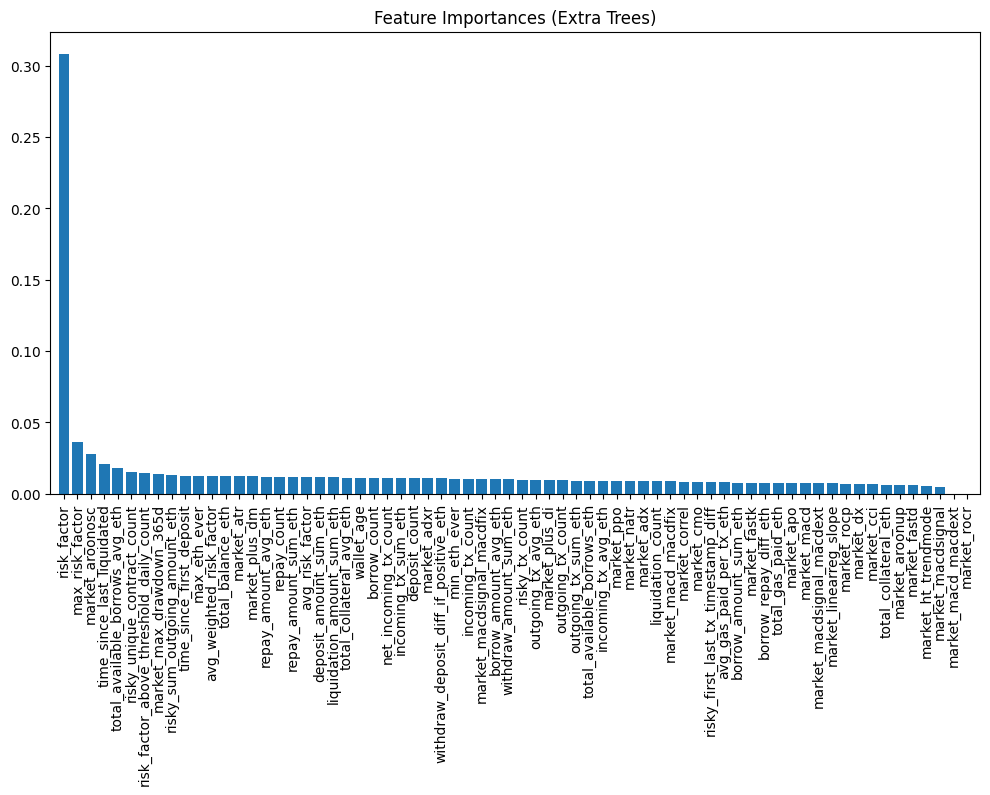

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

xgboost_pipe_interpret= train_model(
    model= XGBClassifier(),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Extra Trees: n_estimators=100, random_state=42",
    numeric_features=train_numeric_features
)
et_model = xgboost_pipe_interpret.named_steps["classifier"]
importances = et_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Extra Trees)")
preprocessed_X_train = xgboost_pipe_interpret.named_steps["preprocessor"].transform(X_train)

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

# Entrega Etapa 2 

A continuación se realiza la optimización del mejor modelo encontrado en la primera entrega del proyecto, para ello se optimizará los hiperparámetros del modelo y de los preprocesadores utilizados.

## Optimización de modelos

Se utilizará `Optuna` para la búsqueda de hiperparámetros y también se probarán técnicas de selección de atributos.

## Re-entrenamiento del modelo

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Primero el entrenamiento normal
model_final = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
extra_tree_pipe_retrain = train_model(
    model=model_final,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    experiment_name="Modelo Incremental",
    numeric_features=train_numeric_features,
    save_model_path="extra_tree_model_pre_retrain.pkl",
)

Evaluación del modelo en el conjunto de entrenamiento:
Métricas del modelo:
    accuracy: 0.9512368174928242
    precision: 0.9786481617401748
    recall: 0.9248376316287281
    f1_score: 0.9509822991635869
    roc_auc: 0.9916981588457949
Confusion matrix:
[[14828   320]
 [ 1192 14667]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     15148
           1       0.98      0.92      0.95     15859

    accuracy                           0.95     31007
   macro avg       0.95      0.95      0.95     31007
weighted avg       0.95      0.95      0.95     31007

Evaluación del modelo en el conjunto de validación:
Métricas del modelo:
    accuracy: 0.885009030704395
    precision: 0.9146725440806045
    recall: 0.8549146556798116
    f1_score: 0.8837846060237299
    roc_auc: 0.9515175013245804
Confusion matrix:
[[2975  271]
 [ 493 2905]]
Classification report:
              precision    recall  f1-score   support

    

In [ ]:
X_t1_iter_1 = pd.read_parquet(DATA_PATH + "X_t1_new.parquet").reset_index(drop=True)
y_t1_iter_1 = pd.read_parquet(DATA_PATH + "y_t1.parquet").reset_index(drop=True)

df_t1_iter_1 = pd.concat([X_t1_iter_1, y_t1_iter_1], axis=1)

df_t1_iter_1_columns_dropped = df_t1_iter_1.drop(columns=columns_to_drop, inplace=False)

X_t1_iter_1 = df_t1_iter_1_columns_dropped.drop(columns='target')
y_t1_iter_1 = df_t1_iter_1_columns_dropped['target']

X_t1_iter_1.head()

In [ ]:
# splits de nuevos datos
X_train_iter_1, X_val_iter_1, y_train_iter_1, y_val_iter_1 = train_test_split(
    X_t1_iter_1, y_t1_iter_1, train_size=0.7, stratify=y_t1_iter_1, random_state=42
)

In [ ]:
def function_to_retrain_XGB(model_path, X_train, y_train):
    import xgboost as xgb

    with open(model_path, "rb") as f:
        model: xgb.XGBClassifier = pickle.load(f)
    # We use save_model function of xgboost to save the model
    model.save_model("tmp_model.model")
    # We use the train method of xgboost to update the model
    xgb.train(
        model.get_params(),
        xgb.DMatrix(X_train, label=y_train),
        num_boost_round=10,
        xgb_model="tmp_model.model",
    )
    # Remove the temporary model
    os.remove("tmp_model.model")
    return model

In [ ]:
retrained_pipe, retrained_model = train_model(
    model="extra_tree_model_pre_retrain.pkl",
    X_train=X_train_iter_1,
    y_train=y_train_iter_1,
    X_val=X_val_iter_1,
    y_val=y_val_iter_1,
    experiment_name="Modelo Incremental",
    numeric_features=train_numeric_features,
    retrain=True,
    save_model_path="extra_tree_model_post_retrain.pkl",
    preprocessor=preprocessor_retrain,
    fun_to_update_model=function_to_retrain_XGB,
)

In [ ]:
import os
import matplotlib.pyplot as plt

# Crear directorio para guardar los resultados
output_dir = "shap_results_xgb"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import shap
model = extra_tree_pipe_retrain.named_steps["classifier"] # Seleccionar el modelo entrenado
X_val_transformed = preprocessor_retrain.transform(X_val_iter_1)


In [ ]:
explainer = shap.Explainer(model.predict, X_val_transformed)
shap_values = explainer(X_val_transformed) #se demora muchísimo
# disminuir el tiempo de ejecución para el explainer

In [ ]:
shap_values.values[1,:]

In [ ]:
idx=2  #acorde a lo anterior modificar adecuadamente este indice
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

In [ ]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

In [ ]:
color = model.predict(X) # predicción para todo el conjunto de datos

for name in feature_importance_names[:3]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                       color=color, 
                       xmin=0) 

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_val_iter_1, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Dot)")
plt.close()

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_val_iter_1, plot_type="violin", show=False)
plt.title("SHAP Beeswarm Plot")
plt.close()

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_val_iter_1, plot_type="bar", show=False)
plt.title("SHAP Bar Plot")
plt.close()


## Tracking de experimentos con MLflow

Para visualizar la interfaz gráfica con el progreso de los experimentos, se debe ejecutar la siguiente celda que corre el comando `mlflow ui` en el directorio actual, y luego abrir el navegador en la dirección: `localhost:5000`.

In [ ]:
!mlflow ui

## Monitoreo


In [88]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu
from scipy.stats import cramervonmises_2samp

def detect_drift(train_data, production_data, features, target_column, method='ks', alpha=0.05): #ks, mw, cv
    drift_detected = False

    for feature in features:
        train_feature = train_data[feature]
        prod_feature = production_data[feature]
        
        if method == 'ks':
            # Prueba Kolmogorov-Smirnov
            stat, p_value = ks_2samp(train_feature, prod_feature)
        elif method == 'mw':
            # Prueba Mann-Whitney U
            stat, p_value = mannwhitneyu(train_feature, prod_feature, alternative='two-sided')
        elif method == 'cv':
            # Prueba Cramér-von Mises
            stat, p_value = cramervonmises_2samp(train_feature, prod_feature)
        
        if p_value < alpha:
            drift_detected = True
            break

    target_train = train_data[target_column]
    target_prod = production_data[target_column]

    if method == 'ks':
        target_stat, target_p_value = ks_2samp(target_train, target_prod)
    elif method == 'mw':
        target_stat, target_p_value = mannwhitneyu(target_train, target_prod, alternative='two-sided')
    elif method == 'cv':
        target_stat, target_p_value = cramervonmises_2samp(target_train, target_prod)
    
    target_drift_detected = target_p_value < alpha
    
    
    return drift_detected, target_drift_detected


In [ ]:
features_to_check = ['target'] #completar según correspondaaaa
data_train = X_t0
data_production = X_t1_iter_1
for feature in features_to_check:
    plt.figure(figsize=(8, 5))
    plt.hist(data_train[feature], bins=30, alpha=0.5, label='Train Data', density=True)
    plt.hist(data_production[feature], bins=30, alpha=0.5, label='Production Data', density=True)
    plt.title(f"Distribuciones de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Densidad")
    plt.legend()
    plt.show()